In [81]:
import pandas as pd
from pydantic import BaseModel, Field
import datetime
import requests
import matplotlib.pyplot as plt
import zipfile
import io
import os
from tqdm import tqdm
from distance_calculator import calculate_distance
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import geopandas as gpd


class FlightAnalysis(BaseModel):
    """
    A class for analyzing flight data which includes methods for updating route distances, 
    plotting airports by country, analyzing flight distance distribution, plotting flight routes 
    from an airport, plotting the top airplane models, and plotting flights on a world map.
    
    Attributes:
        data_url (str): URL to download the flight data from.
        date_created (datetime.date): Date when the instance was created.
        airline_data (pd.DataFrame): DataFrame containing data on airlines.
        aircraft_data (pd.DataFrame): DataFrame containing data on aircraft.
        airport_data (pd.DataFrame): DataFrame containing data on airports.
        flight_routes (pd.DataFrame): DataFrame containing data on flight routes.
    
    Methods:
        update_route_distances: Calculates and optionally saves the distances between airports.
        plot_airports_by_country: Plots the airports located in the given country.
        distance_analysis: Plots a histogram of the distribution of flight distances.
        plot_flights_from_airport: Plots all flights departing from the given airport.
        plot_top_airplane_models: Plots the most used airplane models.
        plot_flights_on_map: Plots flight routes from or within a specified country on a world map.
    """

    class Config:
        arbitrary_types_allowed = True

    data_url: str = Field(
        default="https://gitlab.com/adpro1/adpro2024/-/raw/main/Files/flight_data.zip?inline=false"
    )
    date_created: datetime.date = Field(default_factory=datetime.date.today)
    
    airline_data: pd.DataFrame = None
    aircraft_data: pd.DataFrame = None
    airport_data: pd.DataFrame = None
    flight_routes: pd.DataFrame = None

    def __init__(self, **data):
        """
        Initializes the FlightAnalysis class by downloading and extracting the flight data.
        
        Args:
            **data: Variable length keyword arguments.
        """
        super().__init__(**data)
        
        # Setting up directory to store the flight data files
        download_dir = "./downloads"
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            response = requests.get(self.data_url, stream=True)
            response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
                zip_ref.extractall(download_dir)
        except requests.exceptions.HTTPError as err:
            os.rmdir(download_dir)
            raise ValueError(f"Download failed with status code {response.status_code}: {err}")

        try:
            self.airline_data = pd.read_csv(f"{download_dir}/airlines.csv")
            self.aircraft_data = pd.read_csv(f"{download_dir}/airplanes.csv")
            self.airport_data = pd.read_csv(f"{download_dir}/airports.csv")
            self.flight_routes = pd.read_csv(f"{download_dir}/routes.csv")
            self.flight_routes.drop(columns=["Airline", "Source airport", "Destination airport"], inplace=True)
            self.airport_data["Airport ID"] = self.airport_data["Airport ID"].astype(str)
        except FileNotFoundError as exc:
            raise FileNotFoundError(f"File not found during data setup: {exc}")

    def __str__(self):
        """String representation of the FlightDataAnalysis instance."""
        return f"FlightDataAnalysis created on {self.date_created}, using data from {self.data_url}"
    
    # Additional methods go here, with docstrings similar to the one above for __init__.

    def update_route_distances(self, save=False, path=None, load_from=None):
        """
        Calculate distances between airports using latitude and longitude coordinates and 
        update the flight_routes DataFrame with these calculated distances. 
        Optionally, save the updated DataFrame to a CSV file.
        
        Args:
            save (bool): Whether to save the DataFrame to a CSV file. Defaults to False.
            path (str): The path to save the CSV file if save is True. Defaults to None.
            load_from (str): The path to load the route distances CSV file. Defaults to None.
        """
        if load_from:
            # If a path is provided for loading data, load the data from that path.
            self.flight_routes = pd.read_csv(load_from)
        else:
            # If no path is provided, calculate the distances and update the DataFrame.
            def get_distance(row):
                # Nested function to calculate distance based on a row of the DataFrame.
                source_airport = self.airport_data.loc[self.airport_data['Airport ID'] == row['Source airport ID']]
                dest_airport = self.airport_data.loc[self.airport_data['Airport ID'] == row['Destination airport ID']]
                if not source_airport.empty and not dest_airport.empty:
                    return calculate_distance(
                        source_airport.iloc[0]['Latitude'], source_airport.iloc[0]['Longitude'],
                        dest_airport.iloc[0]['Latitude'], dest_airport.iloc[0]['Longitude']
                    )
                else:
                    return None

            # Apply the get_distance function to each row in the flight_routes DataFrame.
            self.flight_routes['Distance'] = self.flight_routes.apply(get_distance, axis=1)

        if save:
            # If save is True, write the DataFrame to the specified path or to a default path.
            save_path = path if path else "./downloads/updated_routes.csv"
            self.flight_routes.to_csv(save_path, index=False)


    #Method 3.1
    def plot_airports_by_country(self, country_name):
        
            country_airports = self.airport_data[self.airport_data["Country"] == country_name]
            """
            Plot the airports located in a specific country using geopandas.
        
            Args:
                country_name (str): The name of the country for which to plot the airports.
            """
            # Method implementation ...
            if country_airports.empty:
                print(f"No airports found in {country_name}. Please check the country name and try again.")
                return
            
            world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
            country_map = world[world.name == country_name]

            if country_map.empty:
                print(f"Country {country_name} not found in the map dataset. Please check the country name and try again.")
                return

            gdf = gpd.GeoDataFrame(country_airports, geometry=gpd.points_from_xy(country_airports.Longitude, country_airports.Latitude))

            fig, ax = plt.subplots(figsize=(10, 10))
            country_map.plot(ax=ax, color='lightgrey')
            gdf.plot(ax=ax, color='red', marker='o', markersize=50, label='Airports')

            plt.title(f"Airports in {country_name}")
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.legend()
            plt.show()
                   
    def __str__(self):
        return f"FlightDataAnalysis created on {self.date_created}, using data from {self.data_url}"
    
    
    # Method 3.2
    def distance_analysis(self, display_plot=True, save_plot=False, filename='flight_distance_distribution.png'):
        """
        Plot a histogram of the distribution of flight distances for all flights.
        
        Args:
            display_plot (bool): Whether to display the plot. Defaults to True.
            save_plot (bool): Whether to save the plot to a file. Defaults to False.
            filename (str): The filename to save the plot if save_plot is True. 
                            Defaults to 'flight_distance_distribution.png'.
        """
        # Method implementation ...
        
        if hasattr(self, 'flight_routes') and 'Distance' in self.flight_routes.columns:
            # Plotting the distribution
            plt.figure(figsize=(10, 6))
            plt.hist(self.flight_routes['Distance'].dropna(), bins=50, color='blue', edgecolor="black")
            plt.title('Distribution of Flight Distances')
            plt.xlabel('Distance (km)')
            plt.ylabel('Number of Flights')
            
            # Display the plot if requested
            if display_plot:
                plt.show()
            
            # Save the plot to a file if requested
            if save_plot:
                plt.savefig(filename)
            else:
                print("Flight distance data is not available.")
    
    
    #Method 3.3

    def plot_flights_from_airport(self, airport: str, internal: bool = False):
        """
        Plot all flights departing from a specified airport on a map using Cartopy.
        If internal is True, only plot flights with destinations within the same country.
        
        Args:
            airport (str): The IATA code of the airport.
            internal (bool): Whether to plot only internal flights. Defaults to False.
        """
        # Method implementation ...
        
        airport_info = self.airport_data[self.airport_data['IATA'] == airport]
        if airport_info.empty:
            print(f"Airport '{airport}' not found.")
            return None
        
        # Extract the airport's location
        airport_coords = airport_info[['Longitude', 'Latitude']].iloc[0]
        airport_id = airport_info['Airport ID'].iloc[0]
        airport_country = airport_info['Country'].iloc[0]

        # Set up the map
        fig = plt.figure(figsize=(15, 10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_global()

        # Plot the airport location
        ax.plot(airport_coords['Longitude'], airport_coords['Latitude'], 
                color='red', linewidth=2, marker='o', transform=ccrs.Geodetic(),
                markersize=10, label=f"{airport} (Departure)")

        # Filter for flights
        flights = self.flight_routes[self.flight_routes['Source airport ID'] == airport_id]
        if internal:
            country_airports = self.airport_data[self.airport_data['Country'] == airport_country]
            country_airports_ids = country_airports['Airport ID'].tolist()
            flights = flights[flights['Destination airport ID'].isin(country_airports_ids)]

        # Plot the flights
        for _, flight in flights.iterrows():
            dest_airport_info = self.airport_data[self.airport_data['Airport ID'] == flight['Destination airport ID']]
            if dest_airport_info.empty:
                continue

            dest_coords = dest_airport_info[['Longitude', 'Latitude']].iloc[0]
            ax.plot([airport_coords['Longitude'], dest_coords['Longitude']], 
                    [airport_coords['Latitude'], dest_coords['Latitude']], 
                    color='blue', linewidth=1, marker='', transform=ccrs.Geodetic())

        # Customize the plot
        ax.set_title(f"Flights from {airport}", pad=20)
        plt.legend(loc='upper left')
        plt.show()

    # Method 3.4

    def plot_top_airplane_models(self, countries=None, N=5):
        """
        Plot the n most used airplane models by number of routes.

        Args:
            countries (str or list of str): A country or a list of countries to filter the routes.
                                            Defaults to None.
            N (int): Number of airplane models to plot. Defaults to 5.
        """
        # filter routes by country
        if countries is not None:
            if isinstance(countries, str):
                countries = [countries]
            # Merge routes with airports to get country information
            filtered_routes = self.flight_routes.merge(
                self.airport_data, left_on="Source airport ID", right_on="IATA"
            )
            filtered_routes = filtered_routes[
                filtered_routes["Country"].isin(countries)
            ]
        else:
            filtered_routes = self.flight_routes

        # count the number of routes for each airplane model
        airplane_model_counts = filtered_routes["Equipment"].value_counts().head(N)
        plt.figure(figsize=(10, 6))
        airplane_model_counts.plot(kind="bar")
        plt.title(f"Top {N} Airplane Models by Number of Routes")
        plt.xlabel("Airplane Model")
        plt.ylabel("Number of Routes")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()


    # Method 3.5

    def plot_flights_on_map(self, country: str, internal: bool = False):
        """
        Plot flight routes from or within a specified country on a world map using Cartopy.
        If internal is True, only plot internal flights within the same country.
        
        Args:
            country (str): The name of the country.
            internal (bool): Whether to plot only internal flights. Defaults to False.
        """
        # Method implementation ...
        
        if country not in self.airport_data['Country'].values:
            print(f"Country '{country}' not found.")
            return

        # Get all airport IDs in the specified country
        country_airports = self.airport_data[self.airport_data["Country"] == country]

        # Filter flights
        if internal:
            # Internal flights: source and destination both within country
            filtered_flights = self.flight_routes[
                (self.flight_routes["Source airport ID"].isin(country_airports["Airport ID"])) &
                (self.flight_routes["Destination airport ID"].isin(country_airports["Airport ID"]))
            ]
        else:
            # All flights departing from the country
            filtered_flights = self.flight_routes[
                self.flight_routes["Source airport ID"].isin(country_airports["Airport ID"])
            ]

        # Initialize the plot using Cartopy
        fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Set map extent
        if internal:
            min_lon = country_airports['Longitude'].min() - 1
            max_lon = country_airports['Longitude'].max() + 1
            min_lat = country_airports['Latitude'].min() - 1
            max_lat = country_airports['Latitude'].max() + 1
            ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Plot each flight
        for index, flight in filtered_flights.iterrows():
            source = country_airports[country_airports["Airport ID"] == flight["Source airport ID"]].iloc[0]
            dest = self.airport_data[self.airport_data["Airport ID"] == flight["Destination airport ID"]].iloc[0]

            # Draw a line between source and destination
            plt.plot([source["Longitude"], dest["Longitude"]], [source["Latitude"], dest["Latitude"]],
                    color='blue', linewidth=1, marker='o', transform=ccrs.Geodetic())

        # Global or local title
        if internal:
            ax.set_title(f"Internal flights within {country}")
        else:
            ax.set_global()
            ax.set_title(f"Flights from {country}")
        plt.show()

In [ ]:
# Check for the distances

#if __name__ == "__main__":
    #analysis = FlightAnalysis()  # Create an instance of the class
analysis.update_route_distances(save=True)  # Call the method to update route distances

    # Print the first few rows of the flight_routes DataFrame to check distances
print(analysis.flight_routes.head())

In [82]:
analysis = FlightAnalysis()

/var/folders/26/7sr8s37n6nb5g99wv7xjv12r0000gn/T/ipykernel_27357/3081585354.py:142: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


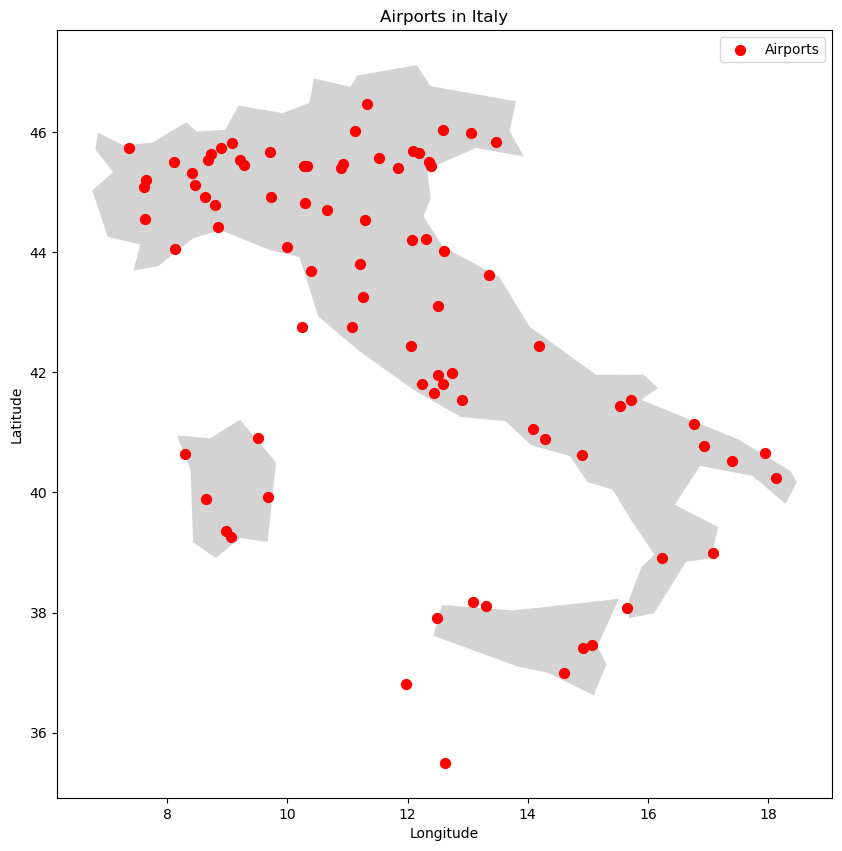

In [83]:

#Check method 3.1
analysis.plot_airports_by_country("Italy")


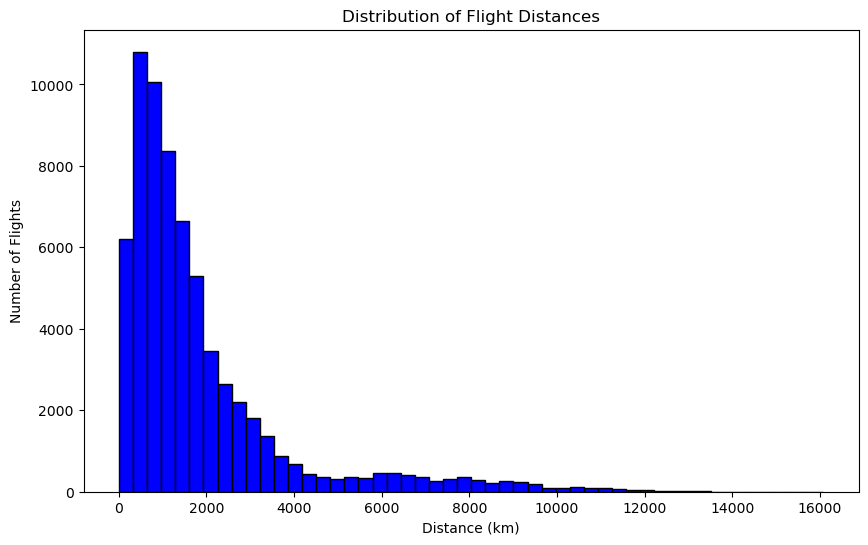

Flight distance data is not available.


In [85]:
# check Method 3.2
analysis.update_route_distances()
analysis.distance_analysis()

In [ ]:
# check method 3.3
flight_data_analysis.plot_flights_from_airport('JFK', internal=False)
flight_data_analysis.plot_flights_from_airport('JFK', internal=True)

In [ ]:
# Check method 3.4
analysis.plot_top_airplane_models(countries='United States', N=5)

In [ ]:
# Check method 3.5 
analysis.plot_flights_on_map("Germany")
analysis.plot_flights_on_map("Germany", internal = True)

In [ ]:
analysis = FlightAnalysis()
display(analysis.airline_data.head())
display(analysis.flight_routes.head())
display(analysis.airport_data.head())
display(analysis.aircraft_data.head())
